In [1]:
import json
import pandas as pd
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
%config NotebookApp.iopub_msg_rate_limit=10000
import time
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import os
os.environ['OMP_NUM_THREADS'] = '4'

In [2]:
with open('Vetting_Playlist.json', 'r') as json_file:
    vetting = json.load(json_file)

In [3]:
#CODE USED TO MAKE 'genreAndArtistFrequencies.csv'

with open('mpd.slice.0-999.json', 'r') as json_file:
    playlistData = json.load(json_file)
with open('songs_0-999.json', 'r') as json_file:
    songData = json.load(json_file)
with open('artists_0-999.json', 'r') as json_file:
    artistData = json.load(json_file)
with open('albums_0-999.json', 'r') as json_file:
    albumData = json.load(json_file)

def findGenresAndArtist(track):
    artist = track['artist_uri']
    artist = artist.split(':')[2]
    if artist in artistData:
        genres = artistData[artist]['genres']
    else:
        genres = []
    return genres, artist

def findModes(lst, n):
    counter = Counter(lst)
    modes = counter.most_common(n)
    return [mode[0] for mode in modes]

def getPlaylistArtists(playlist, modes):
    allArtists = []
    for track in playlist['tracks']:
        artist = track['artist_uri']
        artist = artist.split(':')[2]
        allArtists.append(artist)
    topArtists = findModes(allArtists, modes)
    return topArtists, allArtists
    
def getPlaylistGenres(playlist, modes):
    allGenres = []
    for track in playlist['tracks']:
        genres, a = findGenresAndArtist(track)
        for g in genres:
            allGenres.append(g)
    topGenres = findModes(allGenres, modes)
    return topGenres, allGenres

allGenres = []
allDifGenres = []
allArtists = []
allDifArtists = []
for playlist in playlistData['playlists']:
    for track in playlist['tracks']:
        genres, artist = findGenresAndArtist(track)
        for g in genres:
            allGenres.append(g)
            if not g in allDifGenres:
                allDifGenres.append(g)
        allArtists.append(artist)
        if not artist in allDifArtists:
            allDifArtists.append(artist)

def getFrequency(allList, obj):
    count = 0
    for x in allList:
        if x == obj:
            count += 1
    frequency = round(count/len(allList), 5)
    return frequency

# allPlaylistInfo = pd.DataFrame()
# counter = 1
# for playlist in playlistData['playlists']:
#     genres, x = getPlaylistGenres(playlist, 2)
#     gfs = []
#     for g in genres:
#         f = getFrequency(allGenres, g)
#         gfs.append(f)
#     artists, x = getPlaylistArtists(playlist, 2)
#     afs = []
#     for a in artists:
#         f = getFrequency(allArtists, a)
#         afs.append(f)
#     row = pd.DataFrame({'playlist': [playlist['pid']],
#            'genres': [genres],
#            'genreFrequencies_sum':[sum(gfs)],
#            'artists': [artists],
#            'artistFrequencies_sum':[sum(afs)]})
#     allPlaylistInfo = pd.concat([allPlaylistInfo, row], ignore_index=True).reset_index(drop=True)
#     percentDone = round((counter/len(playlistData['playlists'])*100),2)
#     clear_output(wait=True)
#     time.sleep(0.001)
#     print(str(percentDone) + "% done")
#     counter += 1

In [4]:
allPlaylistInfo = pd.read_csv('genreAndArtistFrequencies.csv')
allPlaylistInfo.head()

,playlist,genres,genreFrequencies_sum,artists,artistFrequencies_sum
0,0,"['pop', 'dance pop']",0.06800,"['2Hjj68yyUPiC0HKEOigcEp', '7bXgB6jMjp9ATFy66e...",0.00418
1,1,"['rock', 'album rock']",0.03561,"['2Hkut4rAAyrQxRdof7FVJq', '7zdmbPudNX4SQJXnYI...",0.00026
2,2,"['k-pop', 'k-pop boy group']",0.00109,"['3Nrfpe0tUJi4K4DXYWgMUX', '4XDi67ZENZcbfKnvMn...",0.00072
3,3,"['indie rock', 'noise pop']",0.00778,"['5juac7bFYyLKmV0VGSyaKM', '2JSc53B5cQ31m0xTB7...",0.00020
4,4,"['pop rock', 'permanent wave']",0.01427,"['40Yq4vzPs9VNUrIBG5Jr2i', '2DaxqgrOhkeH0fpeiQ...",0.00099


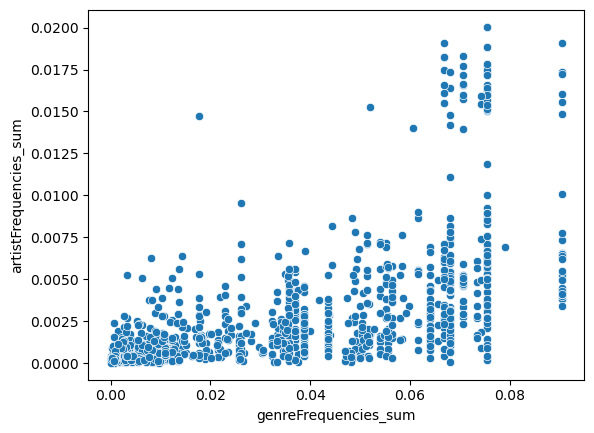

In [5]:
sns.scatterplot(data=allPlaylistInfo, x='genreFrequencies_sum', y='artistFrequencies_sum')
plt.show()

In [6]:
allPlaylistInfo.head()

,playlist,genres,genreFrequencies_sum,artists,artistFrequencies_sum
0,0,"['pop', 'dance pop']",0.06800,"['2Hjj68yyUPiC0HKEOigcEp', '7bXgB6jMjp9ATFy66e...",0.00418
1,1,"['rock', 'album rock']",0.03561,"['2Hkut4rAAyrQxRdof7FVJq', '7zdmbPudNX4SQJXnYI...",0.00026
2,2,"['k-pop', 'k-pop boy group']",0.00109,"['3Nrfpe0tUJi4K4DXYWgMUX', '4XDi67ZENZcbfKnvMn...",0.00072
3,3,"['indie rock', 'noise pop']",0.00778,"['5juac7bFYyLKmV0VGSyaKM', '2JSc53B5cQ31m0xTB7...",0.00020
4,4,"['pop rock', 'permanent wave']",0.01427,"['40Yq4vzPs9VNUrIBG5Jr2i', '2DaxqgrOhkeH0fpeiQ...",0.00099


In [7]:
#batch_size must be between 10-100 (1-10% of datapoints)
len(allPlaylistInfo)

1000

In [8]:
def miniBatchKMeans(df, k):
    batch_size = 55
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=700)
    clusters = minibatch_kmeans.fit_predict(df)
    labels = minibatch_kmeans.fit_predict(df)
    return clusters, labels

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 5120 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 5120 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 5120 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Prog

<AxesSubplot:>

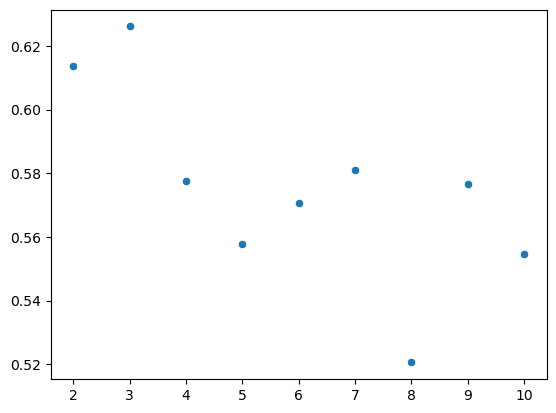

In [9]:
kMeansX = allPlaylistInfo[['genreFrequencies_sum', 'artistFrequencies_sum']]

cluster_range = range(2, 11)

silhouette_scores = {}

for num_clusters in cluster_range:
    clusters, labels = miniBatchKMeans(kMeansX, num_clusters)
    silhouette_scores[num_clusters] = silhouette_score(kMeansX, labels)

sns.scatterplot(x=silhouette_scores.keys(), y=silhouette_scores.values())

In [34]:
clusters, labels = miniBatchKMeans(kMeansX, 3)
kMeansClusters = allPlaylistInfo.copy()
kMeansClusters['cluster'] = clusters

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 5120 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 5120 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [35]:
kMeansClusters.head()

,playlist,genres,genreFrequencies_sum,artists,artistFrequencies_sum,cluster
0,0,"['pop', 'dance pop']",0.06800,"['2Hjj68yyUPiC0HKEOigcEp', '7bXgB6jMjp9ATFy66e...",0.00418,1
1,1,"['rock', 'album rock']",0.03561,"['2Hkut4rAAyrQxRdof7FVJq', '7zdmbPudNX4SQJXnYI...",0.00026,2
2,2,"['k-pop', 'k-pop boy group']",0.00109,"['3Nrfpe0tUJi4K4DXYWgMUX', '4XDi67ZENZcbfKnvMn...",0.00072,0
3,3,"['indie rock', 'noise pop']",0.00778,"['5juac7bFYyLKmV0VGSyaKM', '2JSc53B5cQ31m0xTB7...",0.00020,0
4,4,"['pop rock', 'permanent wave']",0.01427,"['40Yq4vzPs9VNUrIBG5Jr2i', '2DaxqgrOhkeH0fpeiQ...",0.00099,0


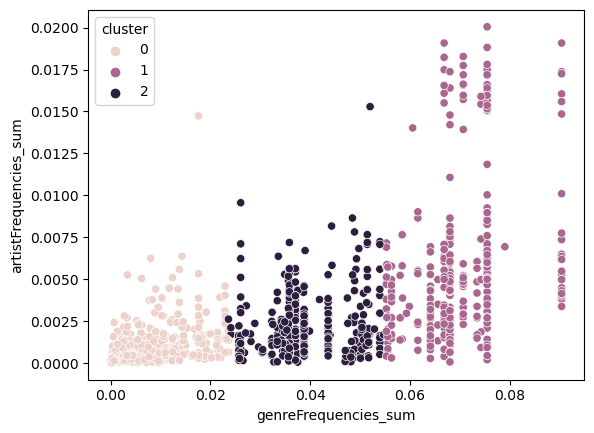

In [36]:
sns.scatterplot(data=kMeansClusters, x='genreFrequencies_sum', y='artistFrequencies_sum', hue='cluster')
plt.show()

In [13]:
def meanShift(df, bw):
    score = -5
    ms = MeanShift(bandwidth=bw)
    ms.fit(df)
    labels = ms.labels_
    if len(set(ms.labels_)) > 1:
        ss_avg = silhouette_score(df.values, labels)
        score = ss_avg
        
    return score, labels

In [14]:
meanShiftX = allPlaylistInfo[['genreFrequencies_sum', 'artistFrequencies_sum']]

bandMin = 0.009
bandMax = 0.011
bandStep = 0.0001
currentBand = bandMin
scores = {}
while currentBand <= (bandMax+(bandStep/2)):
    score, labels = meanShift(meanShiftX, currentBand)
    scores[currentBand] = score
    percentDone = round(((currentBand-bandMin)/bandStep)/((bandMax-bandMin)/bandStep)*100,2)
    clear_output(wait=True)
    time.sleep(0.001)
    print(str(currentBand) + ', ' + str(score) + ', ' + str(percentDone) + "% done")
    currentBand = round(currentBand + bandStep, 6)

0.011, 0.5939417902265607, 100.0% done


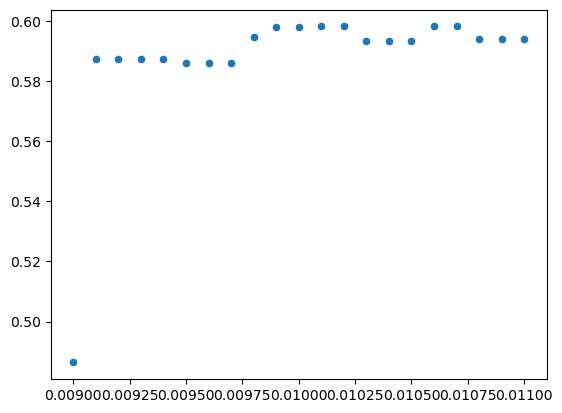

In [15]:
sns.scatterplot(x=scores.keys(), y=scores.values())
plt.show()

In [16]:
scores

{0.009: 0.48640842457993405,
 0.0091: 0.5874300294525854,
 0.0092: 0.5874300294525854,
 0.0093: 0.5874300294525854,
 0.0094: 0.5874300294525854,
 0.0095: 0.5857969437227941,
 0.0096: 0.5857969437227941,
 0.0097: 0.5857969437227941,
 0.0098: 0.5946790821297209,
 0.0099: 0.5978678526343607,
 0.01: 0.5978678526343607,
 0.0101: 0.5980796889779715,
 0.0102: 0.5980796889779715,
 0.0103: 0.593178328354272,
 0.0104: 0.593178328354272,
 0.0105: 0.593178328354272,
 0.0106: 0.5980796889779715,
 0.0107: 0.5980796889779715,
 0.0108: 0.5939417902265607,
 0.0109: 0.5939417902265607,
 0.011: 0.5939417902265607}

In [31]:
score, labels = meanShift(meanShiftX, .0106)
meanShiftClusters = allPlaylistInfo.copy()
meanShiftClusters['cluster'] = labels

In [32]:
meanShiftClusters.head()

,playlist,genres,genreFrequencies_sum,artists,artistFrequencies_sum,cluster
0,0,"['pop', 'dance pop']",0.06800,"['2Hjj68yyUPiC0HKEOigcEp', '7bXgB6jMjp9ATFy66e...",0.00418,1
1,1,"['rock', 'album rock']",0.03561,"['2Hkut4rAAyrQxRdof7FVJq', '7zdmbPudNX4SQJXnYI...",0.00026,2
2,2,"['k-pop', 'k-pop boy group']",0.00109,"['3Nrfpe0tUJi4K4DXYWgMUX', '4XDi67ZENZcbfKnvMn...",0.00072,0
3,3,"['indie rock', 'noise pop']",0.00778,"['5juac7bFYyLKmV0VGSyaKM', '2JSc53B5cQ31m0xTB7...",0.00020,0
4,4,"['pop rock', 'permanent wave']",0.01427,"['40Yq4vzPs9VNUrIBG5Jr2i', '2DaxqgrOhkeH0fpeiQ...",0.00099,0


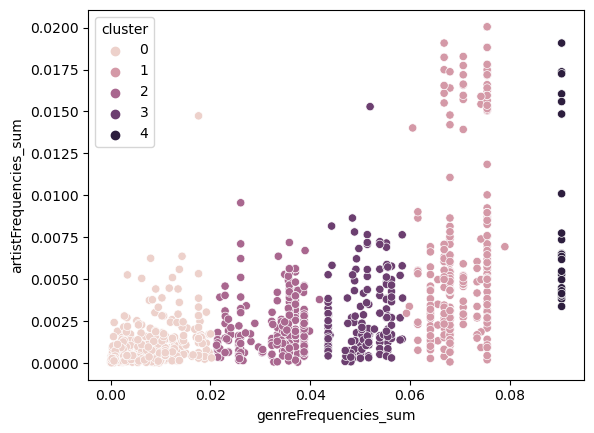

In [33]:
sns.scatterplot(data=meanShiftClusters, x='genreFrequencies_sum', y='artistFrequencies_sum', hue='cluster')
plt.show()

In [20]:
def hierCluster(df, clusters):
    agg = AgglomerativeClustering(n_clusters=clusters, affinity='euclidean', linkage='ward')
    agg = agg.fit(df)
    ss_avg = silhouette_score(df, agg.labels_)
    return ss_avg, agg.labels_

In [21]:
hierX = allPlaylistInfo[['genreFrequencies_sum', 'artistFrequencies_sum']]

scores = {}
clusters = len(hierX)
for i in range(2, clusters):
    score, labels = hierCluster(hierX, i)
    scores[i] = score
    percentDone = round(((i-1)/(clusters-2))*100,2)
    clear_output(wait=True)
    time.sleep(0.001)
    print(str(percentDone) + "% done")

100.0% done


7
0.5957652281067894


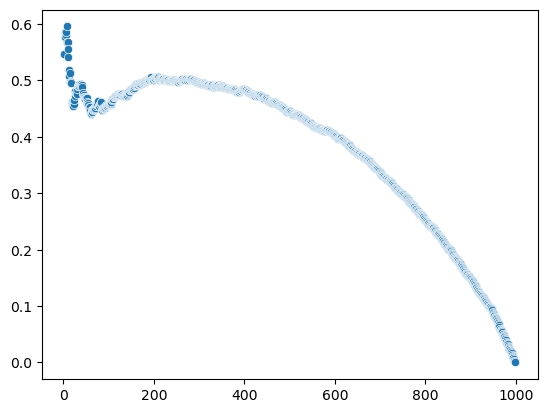

In [37]:
sns.scatterplot(x=scores.keys(), y=scores.values()) #30 is the optimal number of clusters
bestClusters = max(scores, key=scores.get)
print(bestClusters)
print(scores[bestClusters])

In [23]:
score, labels = hierCluster(hierX, bestClusters)
hierClusters = allPlaylistInfo.copy()
hierClusters['cluster'] = labels

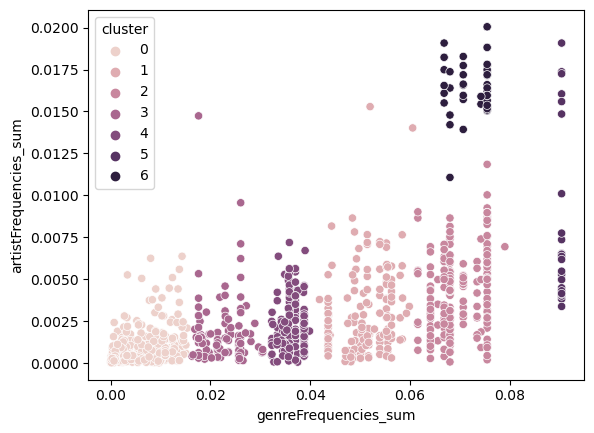

In [24]:
sns.scatterplot(data=hierClusters, x='genreFrequencies_sum', y='artistFrequencies_sum', hue='cluster')
plt.show()

In [25]:
vetting['tracks']['items'][0]['track']['album']['artists'][0]['uri'].split(':')[2]

'16GcWuvvybAoaHr0NqT8Eh'

In [26]:
vettingArtists = []
for i in range(len(vetting['tracks']['items'])):
    artist = vetting['tracks']['items'][i]['track']['album']['artists'][0]['uri'].split(':')[2]
    vettingArtists.append(artist)

In [27]:
vettingGenres = []
for artist in vettingArtists:
    genres = []
    if artist in artistData:
        genres = artistData[artist]['genres']
    else:
        genres = []
    for genre in genres:
        vettingGenres.append(genre)

In [28]:
vettingArtists = findModes(vettingArtists, 2)
vettingGenres = findModes(vettingGenres, 2)
print(vettingArtists, vettingGenres)

['6mKqFxGMS5TGDZI3XkT5Rt', '16GcWuvvybAoaHr0NqT8Eh'] ['indie rock', 'chamber pop']


In [29]:
af = 0
gf = 0
for i in range(len(vettingArtists)):
    f1 = getFrequency(allArtists, vettingArtists[i])
    f2 = getFrequency(allGenres, vettingGenres[i])
    af += f1
    gf += f2
    
vettingInfo = pd.DataFrame({'playlist': ['vetting'],
           'genres': [vettingGenres],
           'genreFrequencies_sum':[gf],
           'artists': [vettingArtists],
           'artistFrequencies_sum':[af]})

In [30]:
vettingInfo #Vetting playlist falls into cluster 0

,playlist,genres,genreFrequencies_sum,artists,artistFrequencies_sum
0,vetting,"[indie rock, chamber pop]",0.01097,"[6mKqFxGMS5TGDZI3XkT5Rt, 16GcWuvvybAoaHr0NqT8Eh]",0.001


In [41]:
cluster0 = hierClusters.loc[hierClusters.loc[:,'cluster'] == 0]
cluster0.head()

,playlist,genres,genreFrequencies_sum,artists,artistFrequencies_sum,cluster
2,2,"['k-pop', 'k-pop boy group']",0.00109,"['3Nrfpe0tUJi4K4DXYWgMUX', '4XDi67ZENZcbfKnvMn...",0.00072,0
3,3,"['indie rock', 'noise pop']",0.00778,"['5juac7bFYyLKmV0VGSyaKM', '2JSc53B5cQ31m0xTB7...",0.00020,0
4,4,"['pop rock', 'permanent wave']",0.01427,"['40Yq4vzPs9VNUrIBG5Jr2i', '2DaxqgrOhkeH0fpeiQ...",0.00099,0
7,7,"['indietronica', 'electropop']",0.01172,"['4Ui2kfOqGujY81UcPrb5KE', '4u5smJBskI6Adzv08P...",0.00090,0
11,11,"['indietronica', 'electronica']",0.00979,"['5CE2IfdYZEQGIDsfiRm8SI', '3iOvXCl6edW5Um0fXE...",0.00068,0


In [45]:
allCluster0Songs = []
for playlist in playlistData['playlists']:
    if playlist['pid'] in cluster0['playlist']:
        for track in playlist['tracks']:
            allCluster0Songs.append(track['track_uri'].split(':')[2])

In [134]:
allVettingSongs = []
for i in range(len(vetting['tracks']['items'])):
    track = vetting['tracks']['items'][i]['track']['uri'].split(':')[2]
    allVettingSongs.append(track)
    
allVettingArtists = []
for i in range(len(vetting['tracks']['items'])):
    artist = vetting['tracks']['items'][i]['track']['album']['artists'][0]['id']
    allVettingArtists.append(artist)

In [135]:
cluster0Playlists = []

for playlist in playlistData['playlists']:
    if playlist['pid'] in cluster0['playlist']:
        cluster0Playlists.append(playlist['pid'])

In [146]:
tracksAndArtists_data = []

for playlist in playlistData['playlists']:
    if playlist['pid'] in cluster0Playlists:
        for track in playlist['tracks']:
            if track['artist_uri'].split(':')[2] in allVettingArtists and not track['track_uri'].split(':')[2] in allVettingSongs:
                uri = track['track_uri'].split(':')[2]
                name = track['track_name']
                artist = track['artist_name']
                tracksAndArtists_data.append({'artist': artist, 'track': name, 'uri': uri})

tracksAndArtists = pd.DataFrame(tracksAndArtists_data)

In [147]:
tracksAndArtists

,artist,track,uri
0,Grizzly Bear,Yet Again,202QyrB6Q3Kimsr7KqJut3
1,Vampire Weekend,Campus,2qpQvKdVtxgTRu4q6xXrL7
2,Dr. Dog,Heart It Races - Dr Dog Version,2vupkXhwL4sNCRgNu72HCZ
3,Spoon,I Turn My Camera On,5uIeRAC9O1ZXPQEEqpPVLL
4,Dan Auerbach,Whispered Words (Pretty Lies),2dqRgUIrAX6Ptads6ttPDw
...,...,...,...
246,Local Natives,Wide Eyes,2fea1IQDXMABCGce4H5dzZ
247,Local Natives,Heavy Feet,6XIWqXj7Tps4dAJ1wSO8Qe
248,Vampire Weekend,Unbelievers,5329hKonR0ej5Tq4xmz5gD
249,Vampire Weekend,Step,1ESlvmyeER7ebaKTsXE78c


In [148]:
topSongs = findModes(tracksAndArtists['track'], 3)

In [149]:
tracksAndArtists.loc[tracksAndArtists.loc[:,'track'].isin(topSongs)]

,artist,track,uri
12,Fleet Foxes,Someone You'd Admire,04FwOgIovwG5ItELDLfPfj
22,Tame Impala,Feels Like We Only Go Backwards,6vTtMyCg96xwpoIBws9K0Q
23,Alabama Shakes,Always Alright,26ZTwQyRVbec9wQ0OaihjE
37,Alabama Shakes,Always Alright,26ZTwQyRVbec9wQ0OaihjE
50,Fleet Foxes,Someone You'd Admire,04FwOgIovwG5ItELDLfPfj
113,Tame Impala,Feels Like We Only Go Backwards,6vTtMyCg96xwpoIBws9K0Q
174,Tame Impala,Feels Like We Only Go Backwards,6vTtMyCg96xwpoIBws9K0Q
191,Fleet Foxes,Someone You'd Admire,04FwOgIovwG5ItELDLfPfj
231,Alabama Shakes,Always Alright,26ZTwQyRVbec9wQ0OaihjE
